# This notebook is some EDA applied on my Spotify streaming data. The tasks herein are as follows:

##Summary tasks
*   Get top 50 artists in streaming history and plot
*   Get top 50 genres in streaming history and plot
*   Average feature values for Top 50 artists and genres seperately

##Clustering and NLP Tasks
*   Cluster each averaged df based on Spotify features and attempt to find the optimal number of clusters using various metrics
*   Load in a Gensim model to apply NLP to tokenized top 50 artists and top 50 genres
*   Cluster based on gensim word2vec transformation of genres and artists
*   Compare results from clustering on average feature values vs word2vec vectorization






In [1]:
import pandas as pd
import numpy as np
import altair as alt
import numpy as np
import seaborn as sb 
import matplotlib.pyplot as plt


In [2]:
dataset = pd.read_csv('full_clf_df.csv')

In [3]:
dataset.head()

,Unnamed: 0,artistName,trackName,msPlayed,genres,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,duration,id,label
0,0,The Killers,Fire In Bone,43760,"['alternative rock', 'dance rock', 'modern roc...",0.569,0.880,-3.740,0.0531,0.01490,96.022,0.227,0.383,233373.0,0WT17Tp3QzUK9zqeGILkuL,0
1,1,Dan Croll,Yesterday,204213,['shimmer pop'],0.518,0.670,-6.850,0.0355,0.00346,85.121,0.318,0.342,204213.0,1zisNk2anwNERJ3JMk5as9,0
2,2,Kygo,Someday,223716,"['edm', 'pop', 'pop dance', 'tropical house']",0.612,0.686,-6.838,0.1200,0.17400,122.115,0.141,0.327,223716.0,73h6Ma5QhBFrshEN2CTevS,1
3,3,Zac Brown Band,You and Islands,230431,"['contemporary country', 'country', 'country r...",0.654,0.727,-5.341,0.0307,0.02640,124.060,0.269,0.669,230431.0,07jaDQMInCqSSjAkQtydgz,0
4,4,070 Shake,Guilty Conscience - Tame Impala Remix,214986,"['alternative r&b', 'new jersey rap']",0.415,0.878,-3.650,0.3200,0.05640,191.777,0.222,0.309,214987.0,5i5fCpsnqDJ9AfeObgd0gW,1


In [4]:
(dataset['artistName'].value_counts()).values

array([65, 58, 47, ...,  1,  1,  1])

In [5]:
def make_bar_chart(x, y):
    
    from matplotlib.ticker import StrMethodFormatter
    from matplotlib.ticker import FuncFormatter

    bar_width = 0.25 # the width of the bars
    plots = []
    opacity = 0.8


    fig = plt.figure()
    ax = plt.gca()
    rects = ax.bar(x= x, height=y,
                    alpha=opacity, color='#5eeb34',
                    label=str(''))

    plt.xticks(rotation=77, )
    plt.xlabel('Artists', size=24, rotation=0)
    plt.title('Top 50 Artists in Streaming History'+str(''),size=18,pad=10)
    plt.ylabel('Appearance Counts', size=20)
    plt.grid(b=True, axis='y')
    #ax.yaxis.set_major_formatter(formatter)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + .6 + rect.get_width()/2., height + 1,
        '{:.0f}'.format(height),
        ha='center', va='bottom', rotation=45)
    
    plt.gcf().set_size_inches(20,7)

    plots.append(fig)
    plt.close()  #used to not generate plots automatically all are stored in list
    return plots
        

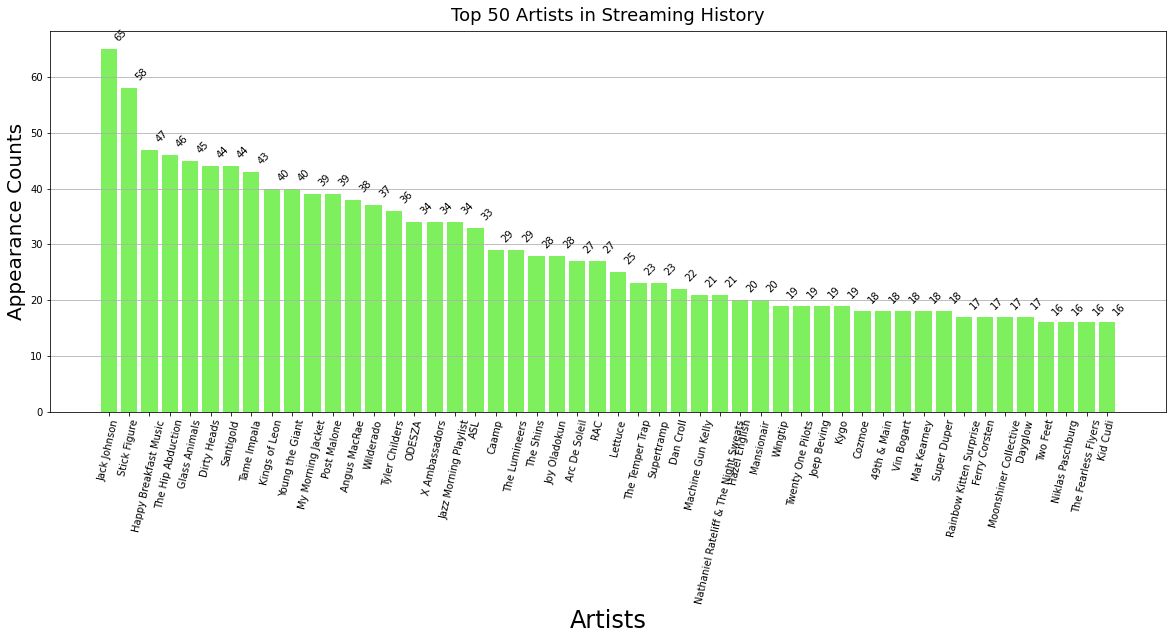

In [6]:
make_bar_chart(x= dataset['artistName'].value_counts().index[0:50], y=dataset['artistName'].value_counts().values[0:50])[0]


In [7]:
from ast import literal_eval

dataset['genres'] = dataset['genres'].apply(literal_eval) #convert to list type
dataset = dataset.explode('genres')

In [219]:
dataset.head()

,Unnamed: 0,artistName,trackName,msPlayed,genres,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,duration,id,label
0,0,The Killers,Fire In Bone,43760,alternative rock,0.569,0.88,-3.74,0.0531,0.0149,96.022,0.227,0.383,233373.0,0WT17Tp3QzUK9zqeGILkuL,0
0,0,The Killers,Fire In Bone,43760,dance rock,0.569,0.88,-3.74,0.0531,0.0149,96.022,0.227,0.383,233373.0,0WT17Tp3QzUK9zqeGILkuL,0
0,0,The Killers,Fire In Bone,43760,modern rock,0.569,0.88,-3.74,0.0531,0.0149,96.022,0.227,0.383,233373.0,0WT17Tp3QzUK9zqeGILkuL,0
0,0,The Killers,Fire In Bone,43760,permanent wave,0.569,0.88,-3.74,0.0531,0.0149,96.022,0.227,0.383,233373.0,0WT17Tp3QzUK9zqeGILkuL,0
0,0,The Killers,Fire In Bone,43760,rock,0.569,0.88,-3.74,0.0531,0.0149,96.022,0.227,0.383,233373.0,0WT17Tp3QzUK9zqeGILkuL,0


In [9]:
def make_bar_chart(x, y):
    
    from matplotlib.ticker import StrMethodFormatter
    from matplotlib.ticker import FuncFormatter

    bar_width = 0.25 # the width of the bars
    plots = []
    opacity = 0.8


    fig = plt.figure()
    ax = plt.gca()
    rects = ax.bar(x= x, height=y,
                    alpha=opacity, color='#5eeb34',
                    label=str(''))

    plt.xticks(rotation=77, )
    plt.xlabel('Genres', size=24, rotation=0)
    plt.title('Top 50 Genres in Streaming History'+str(''),size=18,pad=10)
    plt.ylabel('Appearance Counts', size=20)
    plt.grid(b=True, axis='y')
    #ax.yaxis.set_major_formatter(formatter)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + .6 + rect.get_width()/2., height + 1,
        '{:.0f}'.format(height),
        ha='center', va='bottom', rotation=45)
    
    plt.gcf().set_size_inches(20,7)

    plots.append(fig)
    plt.close()  #used to not generate plots automatically all are stored in list
    return plots
        

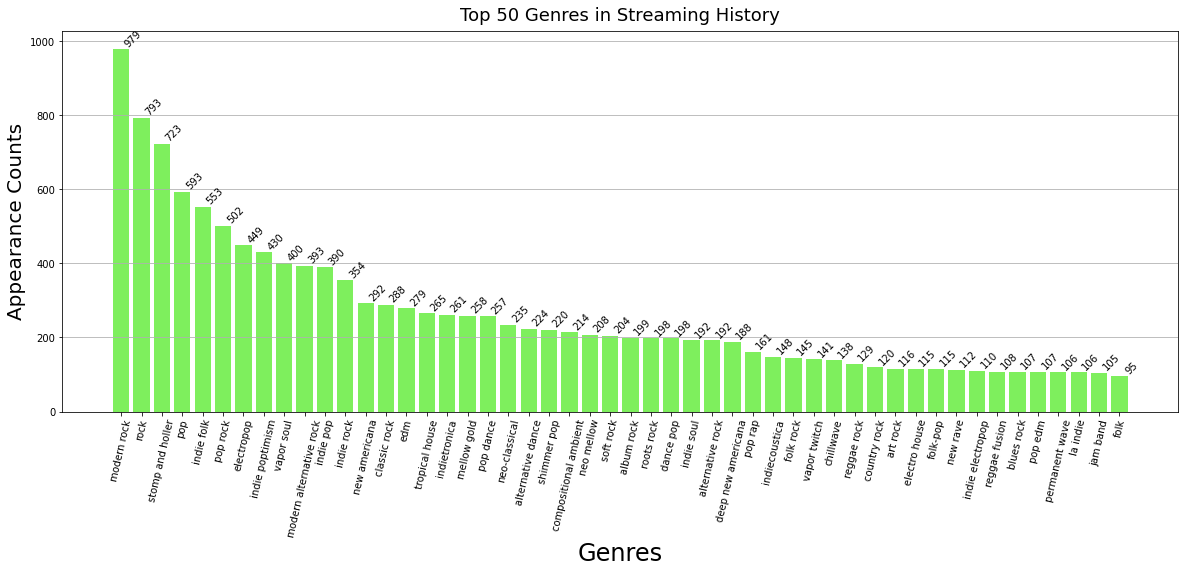

In [10]:
make_bar_chart(x= dataset['genres'].value_counts().index[0:50], y=dataset['genres'].value_counts().values[0:50])[0]

* get average vectors for songs for top 50 artists and genres
* cluster using k means etc

In [60]:
average_df_genres = dataset.groupby('genres').mean()[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'tempo', 'liveness', 'valence', 'duration']]

average_df_artists = dataset.groupby('artistName').mean()[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'tempo', 'liveness', 'valence', 'duration']]

In [57]:
top_50_artists = dataset['artistName'].value_counts().index[0:50]
top_50_genres = dataset['genres'].value_counts().index[0:50]

In [213]:
average_df_artists.loc[top_50_artists].head()

,danceability,energy,loudness,speechiness,acousticness,tempo,liveness,valence,duration
My Morning Jacket,0.483821,0.537282,-8.333615,0.037567,0.250804,128.982923,0.194669,0.399746,297262.743590
The Shins,0.542143,0.690321,-6.981429,0.039521,0.192985,129.575179,0.200750,0.588000,224220.714286
RAC,0.659630,0.605556,-7.594259,0.063615,0.360261,113.603259,0.177933,0.457893,219884.962963
X Ambassadors,0.541441,0.687176,-6.148088,0.078906,0.100938,113.045294,0.182347,0.424529,211494.794118
Supertramp,0.509478,0.559043,-9.237609,0.041491,0.449313,112.087652,0.151883,0.443983,310603.782609


In [12]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [65]:
average_df_artists_top = average_df_artists.loc[top_50_artists]
average_df_genres_top = average_df_genres.loc[top_50_genres]

## Clustering top 50 artists

In [67]:
clust_master = []
for clust in range(2,40):
  clust_dict = {}
  km = KMeans(n_clusters=clust, init='k-means++', max_iter=100,n_init=1,
              verbose=False, random_state=42)
  km.fit(average_df_artists_top)
  clust_dict['Silhouette CoeffecientL'] = metrics.silhouette_score(average_df_artists_top.to_numpy(), km.labels_, sample_size=1000)
  clust_dict['Davies-Bouldin'] = metrics.davies_bouldin_score(average_df_artists_top.to_numpy(), km.labels_)
  clust_dict['Calinksi'] = metrics.calinski_harabasz_score(average_df_artists_top.to_numpy(), km.labels_)
  clust_dict['clusters'] = clust
  clust_master.append(clust_dict)

  # print("Silhouette CoeffecientL %0.3f"
  # % metrics.silhouette_score(average_df, km.labels_, sample_size=1000))
  # print("Davies-Bouldin %0.3f"
  # % metrics.davies_bouldin_score(average_df.to_numpy(), km.labels_))
  # print("Calinksi %0.3f"
  # % metrics.silhouette_score(average_df.to_numpy(), km.labels_))


In [68]:
cluster_df = pd.DataFrame(clust_master)

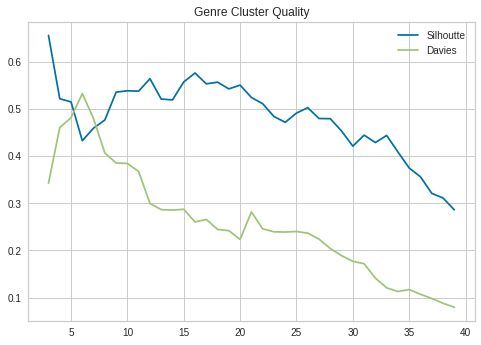

In [69]:
from yellowbrick.cluster import SilhouetteVisualizer
plt.plot(cluster_df['clusters'], cluster_df['Silhouette CoeffecientL'], label='Silhoutte')
plt.plot(cluster_df['clusters'], cluster_df['Davies-Bouldin'], label='Davies')

plt.title('Genre Cluster Quality')
plt.legend()
plt.show()

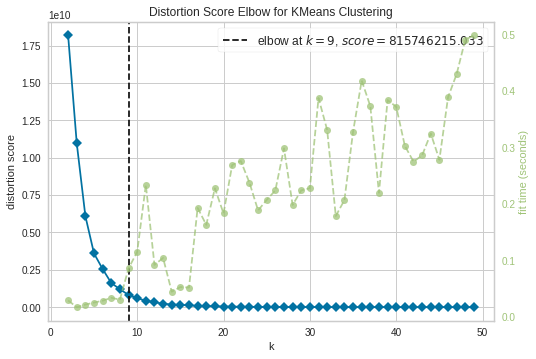

In [71]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,50),)

visualizer.fit(average_df_artists_top)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## calsinki higher the better
## davies lower the better
## silhoutee higher the better

## Checking silhoutte plots of n=2 and n=9 clusters. This is what the elbow score reccomended 

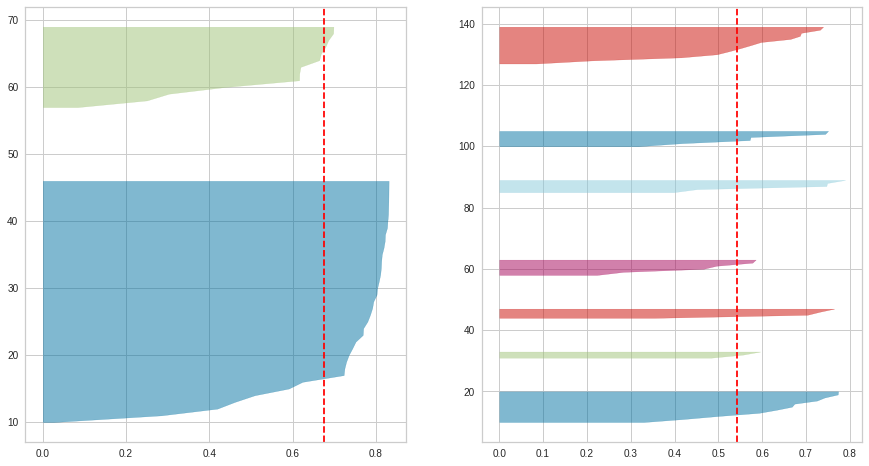

In [141]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(1, 2, figsize=(15,8))
for i,x in zip([2, 9],[0,1]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[x])
    visualizer.fit(average_df_artists_top)

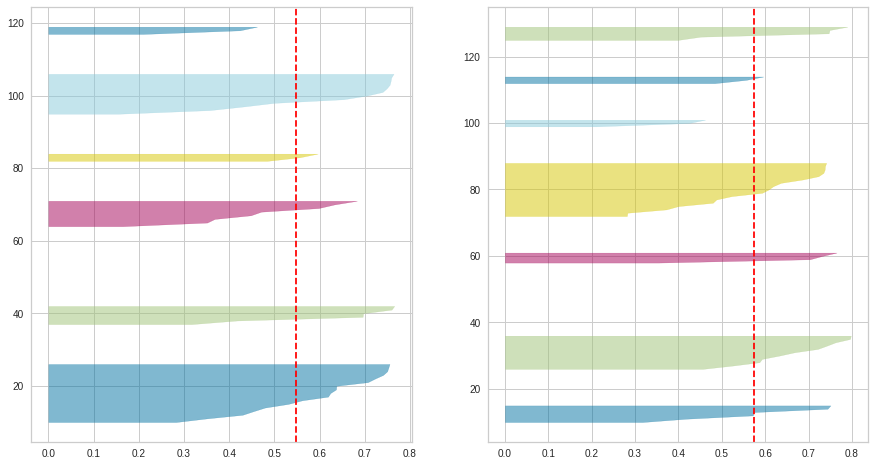

In [142]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(1, 2, figsize=(15,8))
for i,x in zip([7,8],[0,1]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[x])
    visualizer.fit(average_df_artists_top)

## k=9 appears to result in the best clustering, but in general these are not high quality clusters. I'M going to go with two for some NLP comparisons

In [203]:
  km = KMeans(n_clusters=2, init='k-means++', max_iter=100,n_init=1,
              verbose=False, random_state=42)

In [204]:
km.fit(average_df_artists_top)

KMeans(max_iter=100, n_clusters=2, n_init=1, random_state=42, verbose=False)

In [205]:
average_df_artists_top['cluster'] = km.labels_

In [206]:
cluster_1 = average_df_artists_top[average_df_artists_top['cluster'] == 0].index.to_list()
cluster_2 = average_df_artists_top[average_df_artists_top['cluster'] == 1].index.to_list()

In [100]:
cluster_1

['The Shins',
 'RAC',
 'X Ambassadors',
 'Young the Giant',
 'Santigold',
 'Wilderado',
 'The Lumineers',
 'Glass Animals',
 'Mansionair',
 'Ferry Corsten',
 'Post Malone',
 'The Temper Trap',
 'Joy Oladokun',
 'Local Natives',
 'Tyler Childers',
 'Van Morrison',
 'Kasbo',
 'Mat Kearney',
 'Dirty Heads',
 'Syn Cole',
 'Nathaniel Rateliff & The Night Sweats',
 'Kings of Leon',
 'Cold War Kids',
 'Joywave',
 'Sir Sly',
 'The Knocks',
 'Gryffin',
 'Wingtip',
 'Kygo',
 'Shakey Graves',
 'Super Duper',
 'Smallpools',
 'ODESZA',
 'Jack Johnson',
 'ILLENIUM',
 'K.Flay',
 'Kid Cudi']

In [110]:
>>> import nltk
>>> nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [207]:
# from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('&')
clusters_tok =[]
cluster_1 = [i.split() for i in cluster_1]
for i in cluster_1:
  clusters_tok.append([word for word in i if word.lower() not in stop_words])

cluster_2 = [i.split() for i in cluster_2]
for i in cluster_2:
  clusters_tok.append([word for word in i if word.lower() not in stop_words])
# clusters_tok = cluster_1.copy()
# clusters_tok.extend(cluster_2)


In [208]:
clusters_tok[0:10]

[['Shins'],
 ['RAC'],
 ['X', 'Ambassadors'],
 ['Young', 'Giant'],
 ['Santigold'],
 ['Wilderado'],
 ['Lumineers'],
 ['Glass', 'Animals'],
 ['Mansionair'],
 ['Ferry', 'Corsten']]

In [209]:
import gensim
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import pandas as pd
from tqdm.notebook import tqdm
from gensim.models.word2vec import Word2Vec
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.test.utils import datapath

In [210]:
quick_model = Word2Vec(sentences=clusters_tok, seed=20, window=2, min_count=1)

In [211]:
quick_word_vectors = quick_model.wv
quick_word_vectors.similar_by_word('Johnson')

[('Dawes', 0.17021477222442627),
 ('Santigold', 0.16087181866168976),
 ('Floyd', 0.15412278473377228),
 ('Jack', 0.14089980721473694),
 ('Sweats', 0.106345534324646),
 ('Sir', 0.09515026211738586),
 ('Giant', 0.09246227145195007),
 ('Foo', 0.07838347554206848),
 ('Kearney', 0.07608215510845184),
 ('Supertramp', 0.0663592740893364)]

## Importing trained model from gensim

In [139]:
# needed to properly load pre-trained model

# def line_prepender(filename, line):
#     with open(filename, 'r+') as f:
#         content = f.read()
#         f.seek(0, 0)
#         f.write(line.rstrip('\r\n') + '\n' + content)

# line_prepender("glove.6B.300d.txt", "400000 300")

## Clustering artists based on word2vec model 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


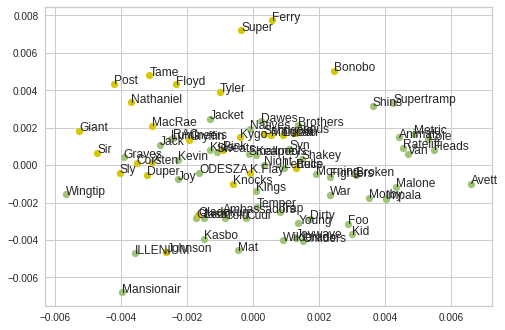

In [215]:
# # from gensim.models import KeyedVectors

# model_2 = Word2Vec(size=300, min_count=1)
# model_2.build_vocab(clusters_tok)
# total_examples = model_2.corpus_count
# model = KeyedVectors.load_word2vec_format("glove.6B.300d.txt", binary=False)
# model_2.build_vocab([list(model.vocab.keys())], update=True)
# model_2.intersect_word2vec_format("glove.6B.300d.txt", binary=False, lockf=1.0)
# model_2.train(clusters_tok, total_examples=total_examples, epochs=model_2.iter)

# mm = Word2Vec(size=300, min_count=1, )
# mm.build_vocab(clusters_tok)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# fit a 2d PCA model to the vectors
X = model_2[mm.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
kmm = KMeans(n_clusters=2)
kmm.fit(X)
colors = ['y', 'g', 'b']
for i in range(0,len(result)):
  plt.scatter(result[i][0], result[i][1],color = colors[kmm.labels_[i]] )

words = list(mm.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

## Clustering artists based on average features from streaming history

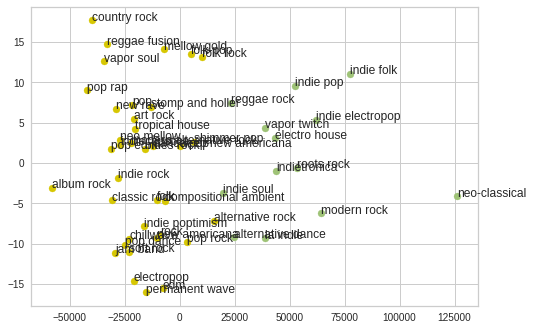

In [217]:
X = average_df_artists_top
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

kmm = KMeans(n_clusters=2)
kmm.fit(X)
colors = ['y', 'g', 'b']
for i in range(0,len(result)):
  plt.scatter(result[i][0], result[i][1],color = colors[kmm.labels_[i]] )

words = list(average_df_genres_top.index)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [125]:
len(list(mm.wv.vocab))

83

## Top 50 Genres Section

In [143]:
clust_master = []
for clust in range(2,40):
  clust_dict = {}
  km = KMeans(n_clusters=clust, init='k-means++', max_iter=100,n_init=1,
              verbose=False, random_state=42)
  km.fit(average_df_genres_top)
  clust_dict['Silhouette CoeffecientL'] = metrics.silhouette_score(average_df_genres_top.to_numpy(), km.labels_, sample_size=1000)
  clust_dict['Davies-Bouldin'] = metrics.davies_bouldin_score(average_df_genres_top.to_numpy(), km.labels_)
  clust_dict['Calinksi'] = metrics.calinski_harabasz_score(average_df_genres_top.to_numpy(), km.labels_)
  clust_dict['clusters'] = clust
  clust_master.append(clust_dict)

  # print("Silhouette CoeffecientL %0.3f"
  # % metrics.silhouette_score(average_df, km.labels_, sample_size=1000))
  # print("Davies-Bouldin %0.3f"
  # % metrics.davies_bouldin_score(average_df.to_numpy(), km.labels_))
  # print("Calinksi %0.3f"
  # % metrics.silhouette_score(average_df.to_numpy(), km.labels_))


In [144]:
cluster_df = pd.DataFrame(clust_master)

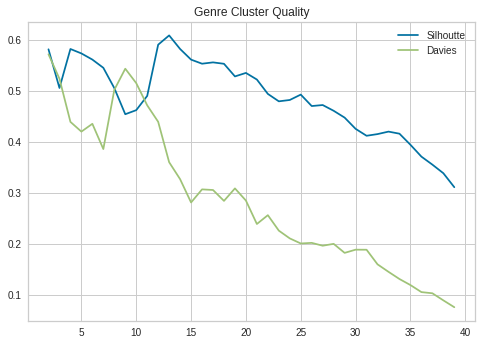

In [145]:
from yellowbrick.cluster import SilhouetteVisualizer
plt.plot(cluster_df['clusters'], cluster_df['Silhouette CoeffecientL'], label='Silhoutte')
plt.plot(cluster_df['clusters'], cluster_df['Davies-Bouldin'], label='Davies')

plt.title('Genre Cluster Quality')
plt.legend()
plt.show()

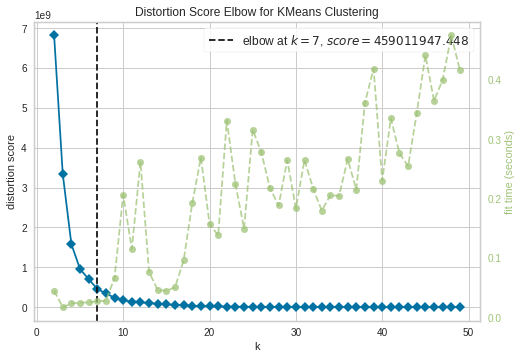

In [146]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,50),)

visualizer.fit(average_df_genres_top)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## calsinki higher the better
## davies lower the better
## silhoutee higher the better

## Checking silhoutte plots of n=2 and n=8 clusters. This is what the elbow score reccomended 

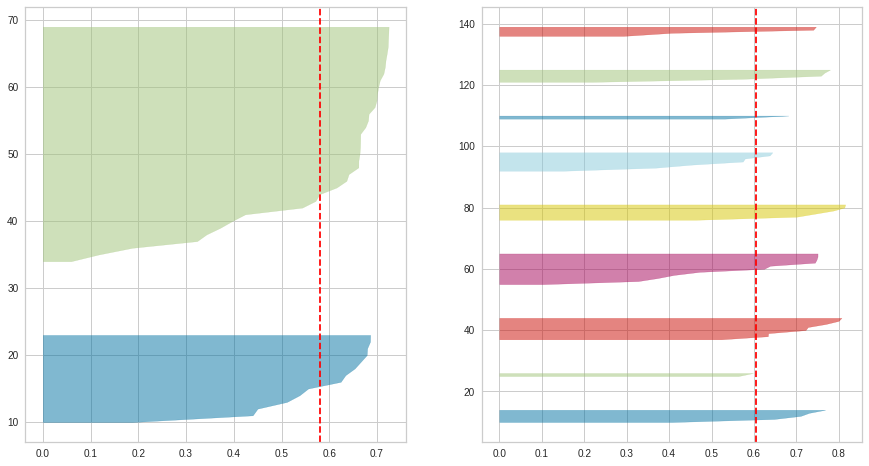

In [148]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(1, 2, figsize=(15,8))
for i,x in zip([2, 9],[0,1]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[x])
    visualizer.fit(average_df_genres_top)

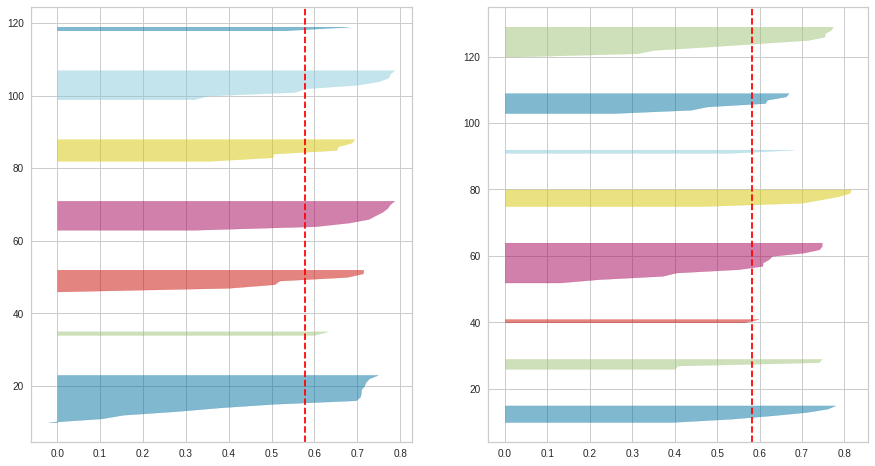

In [149]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(1, 2, figsize=(15,8))
for i,x in zip([7,8],[0,1]):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[x])
    visualizer.fit(average_df_genres_top)

## These are not high quality clusters, but going to go with two for some NLP comparisons

In [150]:
  km = KMeans(n_clusters=2, init='k-means++', max_iter=100,n_init=1,
              verbose=False, random_state=42)

In [151]:
km.fit(average_df_genres_top)

KMeans(max_iter=100, n_clusters=2, n_init=1, random_state=42, verbose=False)

In [152]:
average_df_genres_top['cluster'] = km.labels_

In [153]:
cluster_1 = average_df_genres_top[average_df_genres_top['cluster'] == 0].index.to_list()
cluster_2 = average_df_genres_top[average_df_genres_top['cluster'] == 1].index.to_list()

In [154]:
cluster_1

['rock',
 'indie rock',
 'new americana',
 'classic rock',
 'mellow gold',
 'soft rock',
 'album rock',
 'roots rock',
 'alternative rock',
 'country rock',
 'art rock',
 'blues rock',
 'permanent wave',
 'jam band']

In [155]:
# from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
clusters_tok =[]
cluster_1 = [i.split() for i in cluster_1]
for i in cluster_1:
  clusters_tok.append([word for word in i if word.lower() not in stop_words])

cluster_2 = [i.split() for i in cluster_2]
for i in cluster_2:
  clusters_tok.append([word for word in i if word.lower() not in stop_words])
# clusters_tok = cluster_1.copy()
# clusters_tok.extend(cluster_2)


In [156]:
clusters_tok[0:10]

[['rock'],
 ['indie', 'rock'],
 ['new', 'americana'],
 ['classic', 'rock'],
 ['mellow', 'gold'],
 ['soft', 'rock'],
 ['album', 'rock'],
 ['roots', 'rock'],
 ['alternative', 'rock'],
 ['country', 'rock']]

In [158]:
quick_model = Word2Vec(sentences=clusters_tok, seed=20, window=2, min_count=1)

In [159]:
quick_word_vectors = quick_model.wv
quick_word_vectors.similar_by_word('rock')

[('holler', 0.19797416031360626),
 ('new', 0.19197800755500793),
 ('stomp', 0.15499268472194672),
 ('folk', 0.13922861218452454),
 ('indietronica', 0.12970346212387085),
 ('art', 0.12742793560028076),
 ('fusion', 0.12133125960826874),
 ('deep', 0.1057734340429306),
 ('vapor', 0.10491451621055603),
 ('wave', 0.08794564008712769)]

## Importing trained model from gensim

## Clustering genres based on word2vec model 

In [160]:
# needed to properly load pre-trained model

# def line_prepender(filename, line):
#     with open(filename, 'r+') as f:
#         content = f.read()
#         f.seek(0, 0)
#         f.write(line.rstrip('\r\n') + '\n' + content)

# line_prepender("glove.6B.300d.txt", "400000 300")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


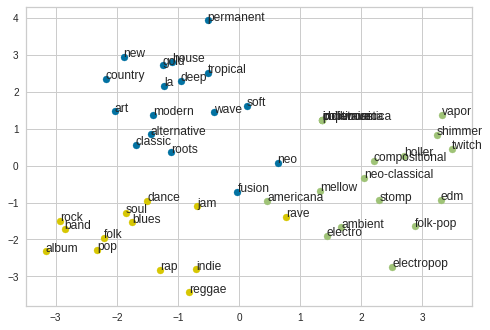

In [ ]:
# from gensim.models import KeyedVectors

# model_2 = Word2Vec(size=300, min_count=1)
# model_2.build_vocab(clusters_tok)
# total_examples = model_2.corpus_count
# model = KeyedVectors.load_word2vec_format("glove.6B.300d.txt", binary=False)
# model_2.build_vocab([list(model.vocab.keys())], update=True)
# model_2.intersect_word2vec_format("glove.6B.300d.txt", binary=False, lockf=1.0)
# model_2.train(clusters_tok, total_examples=total_examples, epochs=model_2.iter)

mm = Word2Vec(size=300, min_count=1, )
mm.build_vocab(clusters_tok)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# fit a 2d PCA model to the vectors
X = model_2[mm.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
kmm = KMeans(n_clusters=3)
kmm.fit(X)
colors = ['y', 'g', 'b']
for i in range(0,len(result)):
  plt.scatter(result[i][0], result[i][1],color = colors[kmm.labels_[i]] )

words = list(mm.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

## compare with clustering of dataframe average values

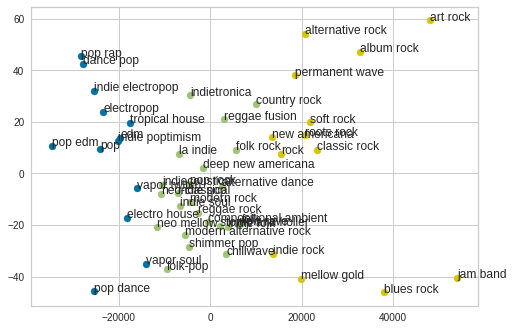

In [218]:
X = average_df_genres_top
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

kmm = KMeans(n_clusters=3)
kmm.fit(X)
colors = ['y', 'g', 'b']
for i in range(0,len(result)):
  plt.scatter(result[i][0], result[i][1],color = colors[kmm.labels_[i]] )

words = list(average_df_genres_top.index)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()